In [144]:
import numpy as np
import random
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib import dates
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
from lmfit import Minimizer,minimize, Parameters, Parameter, report_fit
from statsmodels.tsa.arima_model import ARIMA

# step 0: data importation #

In [145]:
csv_url="https://raw.githubusercontent.com/ADelau/proj0016-epidemic-data/main/data.csv"
data = pd.read_csv(csv_url)

In [146]:
data.tail()

,Day,num_positive,num_tested,num_hospitalised,num_cumulative_hospitalizations,num_critical,num_fatalities
66,67,1550,1942,555,1197,55,38
67,68,1699,2131,608,1297,57,39
68,69,1799,2249,671,1412,62,41
69,70,1884,2372,738,1539,67,41
70,71,2035,2539,774,1654,76,43


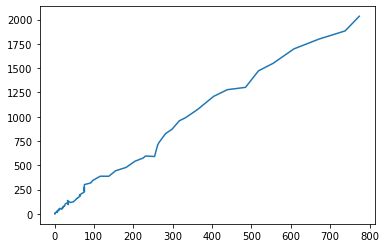

In [147]:
plt.plot(data['num_hospitalised'],data['num_positive'])

# step 1: setting up the model #

## step 1.1: writing the ode system ##

In [148]:

def deriv(y, t, N,ps):
    N=sum(y)
    S,I,R = y
    try:
        beta_SI = ps['beta_SI'].value
        gamma_IR = ps['gamma_IR'].value
        
    except:
        beta_SI, gamma_IR
        
    #beta = beta_i*(1.1-tau*t) idée de faire régresser beta
    dSdt = -beta_SI*(S*I)/(N)
    dIdt = +beta_SI*(S*I)/(N) - gamma_IR*I
    dRdt= +gamma_IR*I
    
    return dSdt, dIdt, dRdt

## step 1.2: writing the parameters values and guesses ##


In [149]:
# the lmfit module uises an orderd dict structure
# to store the parameters to be optimized
# https://lmfit.github.io/lmfit-py/parameters.html

params = Parameters()
params.add('beta_SI', value=0.15, min=0.001, max=10)
params.add('gamma_IR', value= 0.05, min=0.1, max=2)

params.add('I0',value=15,min=1,max=500)

params.add('OBS_Tr_SI_to_nbTest',value=0.25,min=0.05,max=1)
params.add('OBS_nbTest_to_nbpos',value=0.75,min=0.5,max=0.9)
# params.add('OBS_H_to_ICU',value=0.1,min=0.01,max=0.5) mistake??



## step 1.3 writing the solver ##

In [150]:

#this function solves the ode
#input: function deriv, initial compartiments y0, t, and N,ps as arguments??
#output: the ode solution
def odesol(y,t,N,ps):
    
    ts = np.linspace(0, t, t+1)
    result = odeint(deriv, y, ts, args=(N, ps))
    
    return result

In [151]:
test=odesol(np.array([1e6-15,15,0]),3,1e6,params)

In [152]:
test[0]

array([9.99985e+05, 1.50000e+01, 0.00000e+00])

In [153]:
# this function generate the observation dataframe
def create_obsdf(model,ps,data):
    
    result=pd.DataFrame(columns=data.columns)
    result['Day']=data['Day']
    nb_trans_SI=ps['beta_SI']*(model['S']*(model['I']))/(model['S']+model['I']+model['R'])
    

    result['num_tested']=ps['OBS_Tr_SI_to_nbTest'].value*nb_trans_SI
    
    #result['num_hospitalised']=model['H']
    #result['num_cumulative_hospitalizations']=result['num_hospitalised'].diff().fillna(0).cumsum()
    #result['num_critical']=model['ICU']
    #result['num_fatalities']=model['D']
    return result
    

#test['num_tested']=params['OBS_Tr_EI_to_nbTest'].value*

# step 2: fitting the model #

## step 2.1: write objective function ##

In [154]:
#this function compute residuals,
#ie objective function to be minimized in the optimization function
def residual(ps, ts, data, N):
    
    
    I0 = ps['I0'].value
    S0=N-I0
    R0=0

    
    y0 = S0,I0,R0
    
    model = pd.DataFrame(odesol(y0,ts,N,ps), columns=['S','I','R'])
    obs_df=create_obsdf(model,ps,data)
    component1=(obs_df['num_tested']-data['num_tested']).ravel()
    
    # penalty function to think more about !!!
    # print(ps)
    return component1

In [155]:
#residual function from lmfit website
#ts is the x
def residual2(pars, data):
    # unpack parameters: extract .value attribute for each parameter
    parvals = pars.valuesdict()
    beta=parvals['beta_SI']
    gamma=parvals['gamma_IR']
    I0=parvals['I0']
    OBS_Tr_SI_to_nbTest=parvals['OBS_Tr_SI_to_nbTest']
    OBS_nbTest_to_nbpos=parvals['OBS_nbTest_to_nbpos']
    
    # useful scalars, arrays
    
    nb_days=data.shape[0]
    array_data=data['num_tested'].to_numpy()
    array_model=odesol(np.array([1e6-I0,I0,0]),nb_days,1e6,pars)
    
    #array initialisation
    
    ratio_model=np.empty(nb_days)
    ratio_data=np.empty(ratio_model.shape[0])
    
    for i in range(ratio_model.shape[0]-1):
        if array_data[i] == 0: # handle divide by zero
            ratio_data[i]=(array_data[i+1]-array_data[i])/(array_data[i+1]/2)
        else:
            ratio_data[i]=(array_data[i+1]-array_data[i])/array_data[i]
        ratio_model[i]=(array_model[i+1][1]-array_model[i][1])/array_model[i][1]
    

    return ratio_model-ratio_data

## step 2.2: write optimization command ##

In [156]:
residual2(params,data)

array([-1.94873145e+00, -4.48731822e-01, -2.82065548e-01,  3.01267374e-01,
        2.17933607e-01,  1.51266484e-01, -1.39317844e+00,  5.81095575e-03,
        1.38221494e-01, -7.10640346e-01,  1.59371939e-01,  5.12632156e-02,
       -1.00252582e-01, -1.32948637e-01, -1.26516603e-01,  1.45600048e-01,
       -1.36240364e-01, -3.64604946e-02, -7.77743274e-02,  1.94114156e-01,
       -1.15410618e-01,  1.36969320e-01, -2.14371030e-01,  1.74709640e-01,
       -2.58607483e-01,  8.23968068e-03,  7.18676885e-02,  4.07214475e-02,
       -7.37536750e-02, -1.70977409e-01, -1.78707982e-03,  1.95126444e-01,
       -3.68928272e-01,  1.45912505e-01,  3.16281645e-02, -1.98766033e-01,
        3.58472075e-02, -1.91194675e-01,  7.15523997e-02,  2.63284396e-02,
       -1.06672651e-01, -1.30598851e-01,  1.51808153e-01, -1.88918185e-01,
       -2.04078419e-02, -7.73364393e-04, -9.46790536e-02,  7.17334642e-02,
       -1.10229898e-01, -8.37521342e-03, -1.00431141e-01, -5.03029554e-03,
        9.16114787e-03,  

In [157]:
mini = Minimizer(residual2, params, [data])
result = mini.minimize()
result

In [158]:
I0 = result.params['I0'].value

y0 = 1e6-I0,I0,0

model = pd.DataFrame(odesol(y0,70,1e6,result.params), columns=['S','I','R'])
obs_df=create_obsdf(model,result.params,data)
obs_df

KeyError: 'H'

In [159]:
(obs_df['num_tested']-data['num_tested']).ravel()

array([ 3.59890110e+00, -3.85061115e+00, -7.21595140e+00, -1.04842595e+01,
       -5.64071369e+00, -2.66823270e+00, -5.47132531e-01, -1.22547320e+01,
       -1.17648988e+01, -8.04752769e+00, -2.20679414e+01, -1.57862020e+01,
       -1.31563209e+01, -1.51253527e+01, -1.86323572e+01, -2.26072108e+01,
       -1.29692475e+01, -1.66257072e+01, -1.54699660e+01, -1.63795232e+01,
        1.78628593e+00,  1.18888053e+00,  1.80133599e+01,  1.34717963e+01,
        3.78069262e+01,  3.22962658e+01,  4.72566733e+01,  7.10493686e+01,
        9.50854069e+01,  1.11831578e+02,  1.20816675e+02,  1.51638025e+02,
        2.14968126e+02,  2.14561149e+02,  2.87258951e+02,  3.48996148e+02,
        3.83803586e+02,  4.64809409e+02,  5.12236608e+02,  6.25395786e+02,
        7.41671438e+02,  8.40499861e+02,  9.43336503e+02,  1.15061036e+03,
        1.27066301e+03,  1.45767020e+03,  1.67254433e+03,  1.86881764e+03,
        2.15950756e+03,  2.38496840e+03,  2.67473722e+03,  2.92638543e+03,
        3.24339259e+03,  

In [137]:
(data['num_tested'].values[1:] - data['num_tested'].values[:-1])

array([  8,   4,   4,  -4,  -2,  -1,  13,   1,  -2,  16,  -4,   0,   5,
         7,   8,  -5,   9,   5,   8, -10,  10,  -6,  17, -10,  22,   4,
        -2,   1,  12,  24,   7, -20,  50, -16,   3,  39,   3,  48,  -5,
         6,  39,  52, -34,  73,  27,  21,  62, -10,  77,  33,  89,  38,
        30,   1, 126,  48, 100,  87,  66,  41, 133, 146,  78,  58, 174,
       140, 189, 118, 123, 167], dtype=int64)

<ipython-input-138-52de2f40377e>:3: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot((data['num_tested'].values[1:] - data['num_tested'].values[:-1])/data['num_tested'].values[:-1],label='data')


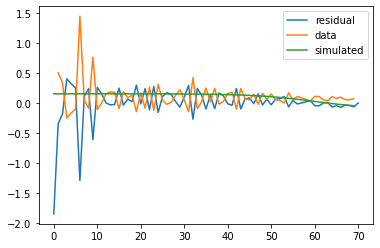

In [138]:
plt.plot(result.residual,label='residual')

plt.plot((data['num_tested'].values[1:] - data['num_tested'].values[:-1])/data['num_tested'].values[:-1],label='data')

plt.plot((obs_df['num_tested'].values[1:] - obs_df['num_tested'].values[:-1])/obs_df['num_tested'].values[:-1],label='simulated')


plt.legend()


In [139]:
y = (data['num_tested'].values[1:] - data['num_tested'].values[:-1])/data['num_tested'].values[:-1]
y[0] = (data['num_tested'].values[1] - data['num_tested'].values[0])/(data['num_tested'].values[1]/2)
R2 = 1 - sum(result.residual**2) / sum((y - np.mean(y))**2)
R2

<ipython-input-139-2da96932929b>:1: RuntimeWarning: divide by zero encountered in true_divide
  y = (data['num_tested'].values[1:] - data['num_tested'].values[:-1])/data['num_tested'].values[:-1]


0.012639516857820499

### simulation of test numbers ##

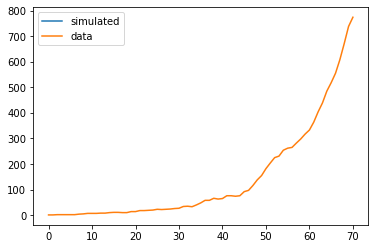

In [143]:
plt.plot(obs_df['num_hospitalised'],label='simulated')
plt.plot(data['num_hospitalised'],label='data')
plt.legend()

## simulation of dI vs I ##

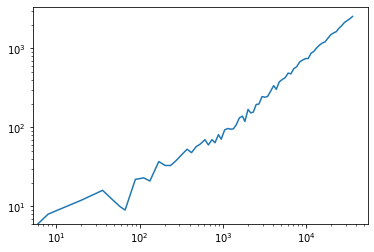

In [141]:
plt.loglog(np.cumsum(data['num_tested']), data['num_tested'])

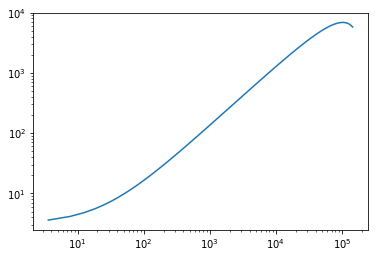

In [142]:
plt.loglog(np.cumsum(obs_df['num_tested']), obs_df['num_tested'])